In [27]:
import pandas as pd
import numpy as np
import os
import pickle

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn.init as init 
import torch.optim as optim

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
folder1 = "/fhome/mapsiv/QuironHelico/CroppedPatches"
folder2 = "/fhome/gia05/project/window_metadata.csv"
folder3 = "/fhome/gia05/project/metadata.csv"

window_metadata = pd.read_csv(folder2)
metadata = pd.read_csv(folder3)

In [4]:
metadata['helicobacter'] = metadata['DENSITAT'].apply(lambda x: 0 if x == 'NEGATIVA' else 1)
metadata

,CODI,DENSITAT,helicobacter
0,B22-01,BAIXA,1
1,B22-02,BAIXA,1
2,B22-03,NEGATIVA,0
3,B22-04,NEGATIVA,0
4,B22-05,NEGATIVA,0
...,...,...,...
304,B22-311,ALTA,1
305,B22-312,ALTA,1
306,B22-313,ALTA,1
307,B22-314,NEGATIVA,0


In [5]:
# Split the DataFrame into two datasets based on the 'helicobacter' column
helicobacter_0 = metadata[metadata['helicobacter'] == 0]
helicobacter_1_baixa = metadata[metadata['DENSITAT'] == "BAIXA"]
helicobacter_1_alta = metadata[metadata['DENSITAT'] == "ALTA"]

In [10]:
class CustomImageDataset(Dataset):
    
    def __init__(self, image_list, transform=None, normalize=True):

        self.image_list = image_list
        
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((256, 256), antialias=True)
        ])

        self.normalize = normalize

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image = self.image_list[idx]
        image = self.transform(image)

        return image, 0

In [14]:
class Autoencoder(nn.Module):
    
    def __init__(self, structure, weight_init):

        super(Autoencoder, self).__init__()

        # Encoder
        encoder_layers = []
        for in_channels, out_channels in zip(structure["encoder"][:-1], structure["encoder"][1:]):
            encoder_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            encoder_layers.append(nn.ReLU())
            encoder_layers.append(nn.MaxPool2d(2, stride=2))
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder
        decoder_layers = []
        for in_channels, out_channels in zip(structure["decoder"][:-1], structure["decoder"][1:]):
            decoder_layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, padding=1))
            decoder_layers.append(nn.ReLU())
            decoder_layers.append(nn.Upsample(scale_factor=2))
        
        decoder_layers.append(nn.Upsample(scale_factor=2))
        decoder_layers.append(nn.ConvTranspose2d(structure["decoder"][-1], 4, kernel_size=3, padding=1))

        self.decoder = nn.Sequential(*decoder_layers)

        # Initialize weights
        if weight_init == "xavier":
            self.initialize_weights_xavier()
        elif weight_init == "he":
            self.initialize_weights_he()
        elif weight_init == "normal":
            self.initialize_weights_normal()

    def initialize_weights_xavier(self):
        for layer in self.modules():
            if isinstance(layer, (nn.Conv2d, nn.ConvTranspose2d)):
                init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    init.zeros_(layer.bias)

    def initialize_weights_he(self):
        for layer in self.modules():
            if isinstance(layer, (nn.Conv2d, nn.ConvTranspose2d)):
                init.kaiming_uniform_(layer.weight)
                if layer.bias is not None:
                    init.zeros_(layer.bias)

    def initialize_weights_normal(self):
        for layer in self.modules():
            if isinstance(layer, (nn.Conv2d, nn.ConvTranspose2d)):
                init.normal_(layer.weight, mean=0, std=0.01)
                if layer.bias is not None:
                    init.zeros_(layer.bias)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [17]:
learning_rate = 0.001
batch_size = 16

weight_init = "xavier"
structure = {"encoder": [4,128, 64, 32,8], "decoder": [8,32, 64, 128]}

# Model
model= Autoencoder(structure=structure, weight_init=weight_init)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Initialize variables
best_loss = np.inf
patience = 3
wait = 0
num_epochs = 50

criterion = nn.MSELoss()

In [19]:
structure = {"encoder": [4,128, 64, 32, 8], "decoder": [8, 32, 64, 128]} # model1

model= Autoencoder(structure=structure, weight_init="xavier")

model.load_state_dict(torch.load("/fhome/gia05/project/helicobacter_detection/model1.pth"))
# Training loop
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(4, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Upsample(scale_factor=2.0, mode='nearest')
    (3): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [20]:
criterion = nn.MSELoss()

def predicted_results_patient(patient, red_pixels_percentages):
    helicobacters = 0

    for percentage in red_pixels_percentages:
        if percentage != 0.0:
            helicobacters += 1

    helicobacter_percentage = helicobacters/len(red_pixels_percentages)
    threshold = 0.1

    print(f"Patient {patient} has {len(red_pixels_percentages)} samples, which {helicobacters} of them contain helicobacters.")
    print(f"Percentage of helicobacters: {helicobacter_percentage*100} %")

    if helicobacter_percentage > threshold:
        print("Result: Positive")
        return 1
    else:
        print("Result: Negative")
        return 0
    print("*******************************************")

We create a subsampling, with 27 patients: 8 for healthy patients, 9 for patients with low density of helicobacters, and 10 for high density of helicobacters.

In [21]:
truth_results = []
datasets = [helicobacter_1_alta, helicobacter_1_baixa, helicobacter_0]

counter = 0
for x in helicobacter_0['helicobacter']:
    if counter < 8:
        truth_results.append(x)
        counter+=1
    else:
        break

counter = 0
for x in helicobacter_1_baixa['helicobacter']:
    if counter < 9:
        truth_results.append(x)
        counter+=1
    else:
        break

counter = 0
for x in helicobacter_1_alta['helicobacter']:
    if counter < 10:
        truth_results.append(x)
        counter+=1
    else:
        break


len(truth_results)

27

In [25]:
predicted_results = []
dictionaries = ['healthy_sample_extended22', 'baixa_sample_extended22', 'alta_sample_extended22']
path = '/fhome/gia05/project/dicts/'

for dictionary in dictionaries:
    print(dictionary)
    final_path = os.path.join(path, dictionary)

    with open(final_path, 'rb') as file:
        loaded_data = pickle.load(file)
        for patient, red_pixels_percentages in loaded_data.items():
            results_patient = predicted_results_patient(patient, red_pixels_percentages)
            predicted_results.append(results_patient)

healthy_sample_extended22
Patient B22-175 has 1819 samples, which 22 of them contain helicobacters.
Percentage of helicobacters: 1.2094557449147882 %
Result: Negative
Patient B22-257 has 948 samples, which 48 of them contain helicobacters.
Percentage of helicobacters: 5.063291139240507 %
Result: Negative
Patient B22-143 has 816 samples, which 2 of them contain helicobacters.
Percentage of helicobacters: 0.24509803921568626 %
Result: Negative
Patient B22-195 has 1382 samples, which 17 of them contain helicobacters.
Percentage of helicobacters: 1.2301013024602026 %
Result: Negative
Patient B22-172 has 2023 samples, which 34 of them contain helicobacters.
Percentage of helicobacters: 1.680672268907563 %
Result: Negative
Patient B22-197 has 881 samples, which 32 of them contain helicobacters.
Percentage of helicobacters: 3.6322360953461974 %
Result: Negative
Patient B22-248 has 3374 samples, which 76 of them contain helicobacters.
Percentage of helicobacters: 2.2525192649673977 %
Result: N

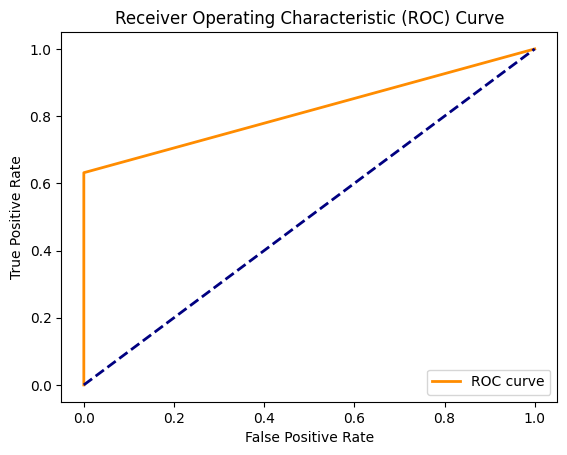

In [26]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt


fpr, tpr, thresholds = roc_curve(truth_results, predicted_results)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [34]:
def compute_metrics(y_truth, y_pred):
    accuracy = round(accuracy_score(y_truth, y_pred), 2)
    precision = round(precision_score(y_truth, y_pred), 2)
    recall = round(recall_score(y_truth, y_pred),2)
    f1 = round(f1_score(y_truth, y_pred), 2)
    
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 score:", f1)
    
    return accuracy, precision, recall, f1

In [41]:
best_accuracy = 0
best_precision = 0
best_recall = 0
best_f1 = 0
best_predictions = []

for threshold in thresholds:
    # Make predictions using this threshold
    better_predictions = [1 if score >= threshold else 0 for score in predicted_results]
    print("\nFor threshold at", threshold)
    print(better_predictions)
    accuracy, precision, recall, f1 = compute_metrics(truth_results, better_predictions)

    if (accuracy > best_accuracy) and (precision > best_precision) and (recall > best_recall) and (f1 > best_f1):
        best_accuracy = accuracy
        best_precision = precision
        best_recall = recall
        best_f1 = f1
        best_predictions = better_predictions


For threshold at inf
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Accuracy: 0.3
Precision: 0.0
Recall: 0.0
F1 score: 0.0

For threshold at 1.0
[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
Accuracy: 0.74
Precision: 1.0
Recall: 0.63
F1 score: 0.77

For threshold at 0.0
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Accuracy: 0.7
Precision: 0.7
Recall: 1.0
F1 score: 0.83


/fhome/gia05/project/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
print(f"\nFinal results: {best_predictions}\n Accuracy: {best_accuracy}\n Precision: {best_precision}\n Recall: {best_recall}\n F1 score: {best_f1}")


Final results: [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
 Accuracy: 0.74
 Precision: 1.0
 Recall: 0.63
 F1 score: 0.77
